In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import keras_core as keras
import keras_nlp
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("TensorFlow version:", tf.__version__)
print("KerasNLP version:", keras_nlp.__version__)

2024-11-16 00:29:36.391892: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731742177.711399   21795 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731742178.038969   21795 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-16 00:29:40.615064: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Using TensorFlow backend


/mnt/c/Users/Jon/python_venv/nlp_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


TensorFlow version: 2.18.0
KerasNLP version: 0.17.0


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [30]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.10 MB


In [31]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [32]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [33]:
BATCH_SIZE = 4
NUM_TRAINING_EXAMPLES = df_train.shape[0]
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2
STEPS_PER_EPOCH = int(NUM_TRAINING_EXAMPLES)*TRAIN_SPLIT // BATCH_SIZE

EPOCHS = 20
AUTO = tf.data.experimental.AUTOTUNE

In [34]:
from sklearn.model_selection import train_test_split

X = df_train["text"]
y = df_train["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SPLIT, random_state=42)

X_test = df_test["text"]

In [35]:
# Load a DistilBERT model.
preset= "distil_bert_base_en_uncased"

# Use a shorter sequence length.
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(preset,
                                                                   sequence_length=80,
                                                                   name="preprocessor_4_tweets"
                                                                  )

# Pretrained classifier.
classifier = keras_nlp.models.DistilBertClassifier.from_preset(preset,
                                                               preprocessor = preprocessor, 
                                                               num_classes=2)

classifier.summary()

2024-11-15 23:25:42.161746: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:497] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.76MiB (rounded to 1850368)requested by op _EagerConst
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-11-15 23:25:42.161858: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1053] BFCAllocator dump for GPU_0_bfc
2024-11-15 23:25:42.161876: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1060] Bin (256): 	Total Chunks: 38, Chunks in use: 38. 9.5KiB allocated for chunks. 9.5KiB in use in bin. 445B client-requested in use in bin.
2024-11-15 23:25:42.161886: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1060] Bin (512): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2024-11-15 23:25:42.161894

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [10]:
# Compile
classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), #'binary_crossentropy',
    optimizer=tf.optimizers.Adam(1e-5),
    metrics= ["accuracy"]  
)

# Fit
history = classifier.fit(x=X_train,
                         y=y_train,
                         batch_size=BATCH_SIZE,
                         epochs=EPOCHS, 
                         validation_data=(X_val, y_val)
                        )

Epoch 1/10


I0000 00:00:1731738092.209522   16022 service.cc:148] XLA service 0x7fdfe8003f70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731738092.209840   16022 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 2050, Compute Capability 8.6
2024-11-15 23:21:32.744732: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1731738094.451755   16022 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-11-15 23:21:37.750283: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_127', 32 bytes spill stores, 32 bytes spill loads

2024-11-15 23:21:37.877900: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_127', 288 bytes 

ResourceExhaustedError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/mnt/c/Users/Jon/python_venv/nlp_env/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/mnt/c/Users/Jon/python_venv/nlp_env/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/mnt/c/Users/Jon/python_venv/nlp_env/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/mnt/c/Users/Jon/python_venv/nlp_env/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/mnt/c/Users/Jon/python_venv/nlp_env/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/mnt/c/Users/Jon/python_venv/nlp_env/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/mnt/c/Users/Jon/python_venv/nlp_env/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/mnt/c/Users/Jon/python_venv/nlp_env/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/mnt/c/Users/Jon/python_venv/nlp_env/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/mnt/c/Users/Jon/python_venv/nlp_env/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/mnt/c/Users/Jon/python_venv/nlp_env/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/mnt/c/Users/Jon/python_venv/nlp_env/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/mnt/c/Users/Jon/python_venv/nlp_env/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/mnt/c/Users/Jon/python_venv/nlp_env/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/mnt/c/Users/Jon/python_venv/nlp_env/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/mnt/c/Users/Jon/python_venv/nlp_env/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/mnt/c/Users/Jon/python_venv/nlp_env/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_15557/1599060515.py", line 9, in <module>

  File "/mnt/c/Users/Jon/python_venv/nlp_env/lib/python3.10/site-packages/keras_hub/src/utils/pipeline_model.py", line 177, in fit

  File "/mnt/c/Users/Jon/python_venv/nlp_env/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/mnt/c/Users/Jon/python_venv/nlp_env/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 320, in fit

  File "/mnt/c/Users/Jon/python_venv/nlp_env/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

Out of memory while trying to allocate 1572864 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:  766.25MiB
              constant allocation:         0B
        maybe_live_out allocation:  766.24MiB
     preallocated temp allocation:    1.12GiB
  preallocated temp fragmentation:   19.76MiB (1.72%)
                 total allocation:    1.87GiB
              total fragmentation:    9.30MiB (0.49%)
Peak buffers:
	Buffer 1:
		Size: 89.42MiB
		Operator: op_type="AssignSubVariableOp" op_name="adam/AssignSubVariableOp" source_file="/mnt/c/Users/Jon/python_venv/nlp_env/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1196
		XLA Label: fusion
		Shape: f32[30522,768]
		==========================

	Buffer 2:
		Size: 89.42MiB
		Operator: op_type="AssignSubVariableOp" op_name="adam/AssignSubVariableOp" source_file="/mnt/c/Users/Jon/python_venv/nlp_env/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1196
		XLA Label: fusion
		Shape: f32[30522,768]
		==========================

	Buffer 3:
		Size: 89.42MiB
		Operator: op_type="AssignSubVariableOp" op_name="adam/AssignSubVariableOp" source_file="/mnt/c/Users/Jon/python_venv/nlp_env/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1196
		XLA Label: fusion
		Shape: f32[30522,768]
		==========================

	Buffer 4:
		Size: 30.00MiB
		Operator: op_type="Mul" op_name="distil_bert_text_classifier_1/distil_bert_backbone_1/transformer_layer_5_1/feedforward_intermediate_dense_1/Gelu/mul_1" source_file="/mnt/c/Users/Jon/python_venv/nlp_env/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1196 deduplicated_name="loop_multiply_fusion"
		XLA Label: fusion
		Shape: f32[2560,3072]
		==========================

	Buffer 5:
		Size: 30.00MiB
		Operator: op_type="BatchMatMulV2" op_name="distil_bert_text_classifier_1/distil_bert_backbone_1/transformer_layer_5_1/feedforward_intermediate_dense_1/MatMul" source_file="/mnt/c/Users/Jon/python_venv/nlp_env/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1196
		XLA Label: custom-call
		Shape: f32[2560,3072]
		==========================

	Buffer 6:
		Size: 30.00MiB
		Operator: op_type="Mul" op_name="distil_bert_text_classifier_1/distil_bert_backbone_1/transformer_layer_4_1/feedforward_intermediate_dense_1/Gelu/mul_1" source_file="/mnt/c/Users/Jon/python_venv/nlp_env/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1196 deduplicated_name="loop_multiply_fusion"
		XLA Label: fusion
		Shape: f32[2560,3072]
		==========================

	Buffer 7:
		Size: 30.00MiB
		Operator: op_type="BatchMatMulV2" op_name="distil_bert_text_classifier_1/distil_bert_backbone_1/transformer_layer_4_1/feedforward_intermediate_dense_1/MatMul" source_file="/mnt/c/Users/Jon/python_venv/nlp_env/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1196
		XLA Label: custom-call
		Shape: f32[2560,3072]
		==========================

	Buffer 8:
		Size: 30.00MiB
		Operator: op_type="Mul" op_name="distil_bert_text_classifier_1/distil_bert_backbone_1/transformer_layer_3_1/feedforward_intermediate_dense_1/Gelu/mul_1" source_file="/mnt/c/Users/Jon/python_venv/nlp_env/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1196 deduplicated_name="loop_multiply_fusion"
		XLA Label: fusion
		Shape: f32[2560,3072]
		==========================

	Buffer 9:
		Size: 30.00MiB
		Operator: op_type="BatchMatMulV2" op_name="distil_bert_text_classifier_1/distil_bert_backbone_1/transformer_layer_3_1/feedforward_intermediate_dense_1/MatMul" source_file="/mnt/c/Users/Jon/python_venv/nlp_env/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1196
		XLA Label: custom-call
		Shape: f32[2560,3072]
		==========================

	Buffer 10:
		Size: 30.00MiB
		Operator: op_type="Mul" op_name="distil_bert_text_classifier_1/distil_bert_backbone_1/transformer_layer_2_1/feedforward_intermediate_dense_1/Gelu/mul_1" source_file="/mnt/c/Users/Jon/python_venv/nlp_env/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1196 deduplicated_name="loop_multiply_fusion"
		XLA Label: fusion
		Shape: f32[2560,3072]
		==========================

	Buffer 11:
		Size: 30.00MiB
		Operator: op_type="BatchMatMulV2" op_name="distil_bert_text_classifier_1/distil_bert_backbone_1/transformer_layer_2_1/feedforward_intermediate_dense_1/MatMul" source_file="/mnt/c/Users/Jon/python_venv/nlp_env/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1196
		XLA Label: custom-call
		Shape: f32[2560,3072]
		==========================

	Buffer 12:
		Size: 30.00MiB
		Operator: op_type="Mul" op_name="distil_bert_text_classifier_1/distil_bert_backbone_1/transformer_layer_1_1/feedforward_intermediate_dense_1/Gelu/mul_1" source_file="/mnt/c/Users/Jon/python_venv/nlp_env/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1196 deduplicated_name="loop_multiply_fusion"
		XLA Label: fusion
		Shape: f32[2560,3072]
		==========================

	Buffer 13:
		Size: 30.00MiB
		Operator: op_type="BatchMatMulV2" op_name="distil_bert_text_classifier_1/distil_bert_backbone_1/transformer_layer_1_1/feedforward_intermediate_dense_1/MatMul" source_file="/mnt/c/Users/Jon/python_venv/nlp_env/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1196
		XLA Label: custom-call
		Shape: f32[2560,3072]
		==========================

	Buffer 14:
		Size: 30.00MiB
		Operator: op_type="Mul" op_name="distil_bert_text_classifier_1/distil_bert_backbone_1/transformer_layer_0_1/feedforward_intermediate_dense_1/Gelu/mul_1" source_file="/mnt/c/Users/Jon/python_venv/nlp_env/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1196 deduplicated_name="loop_multiply_fusion"
		XLA Label: fusion
		Shape: f32[2560,3072]
		==========================

	Buffer 15:
		Size: 30.00MiB
		Operator: op_type="BatchMatMulV2" op_name="distil_bert_text_classifier_1/distil_bert_backbone_1/transformer_layer_0_1/feedforward_intermediate_dense_1/MatMul" source_file="/mnt/c/Users/Jon/python_venv/nlp_env/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1196
		XLA Label: custom-call
		Shape: f32[2560,3072]
		==========================


	 [[{{node StatefulPartitionedCall}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_one_step_on_iterator_24262]

In [9]:
def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        np.argmax(y_pred, axis=1),
        display_labels=["Not Disaster","Disaster"],
        cmap=plt.cm.Blues
    )

    tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
    f1_score = tp / (tp+((fn+fp)/2))

    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)))

191/191 [==============================] - 351s 2s/step


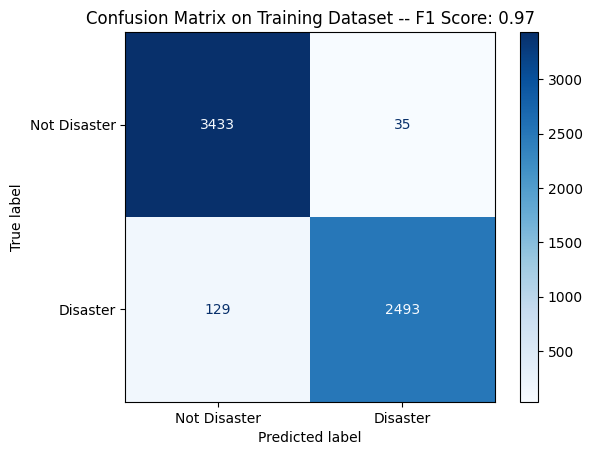

In [10]:
y_pred_train = classifier.predict(X_train)

displayConfusionMatrix(y_train, y_pred_train, "Training")

48/48 [==============================] - 89s 2s/step


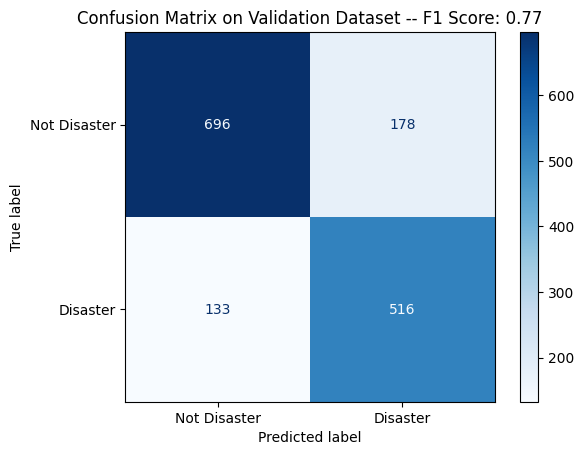

In [11]:
y_pred_val = classifier.predict(X_val)

displayConfusionMatrix(y_val, y_pred_val, "Validation")

In [12]:
sample_submission = pd.read_csv("sample_submission.csv")
sample_submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [13]:
sample_submission["target"] = np.argmax(classifier.predict(X_test), axis=1)

102/102 [==============================] - 205s 2s/step


In [14]:
sample_submission.to_csv("submission_10_epochs.csv", index=False)

KeyboardInterrupt: 